In [3]:
from google.colab import userdata, drive
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from PIL import Image
import re

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download franciscoescobar/satellite-images-of-water-bodies
!unzip "satellite-images-of-water-bodies.zip"

In [3]:
# Load and preprocess images

data_dir = os.getcwd() + '/Water Bodies Dataset'
image_dir = os.path.join(data_dir, 'Images')
mask_dir = os.path.join(data_dir, 'Masks')

def preprocess(image_path, mask_path, target_size=(256, 256)):
  image = tf.image.decode_jpeg(tf.io.read_file(image_path))
  mask = tf.image.decode_png(tf.io.read_file(mask_path), channels=1)

  image = tf.image.resize(image, target_size) / 255.0
  mask = tf.image.resize(mask, target_size)
  mask = tf.cast(mask > 0, tf.float32)

  return image, mask

def load_dataset(image_paths, mask_paths, batch_size=8):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
  dataset = dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset

# Get image and mask paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split into train and validation set
train_image_paths = image_paths[:int(0.8 * len(image_paths))]
train_mask_paths = mask_paths[:int(0.8 * len(mask_paths))]
validation_image_paths = image_paths[int(0.8 * len(image_paths)):]
validation_mask_paths = mask_paths[int(0.8 * len(mask_paths)):]

# Load datasets
train_dataset = load_dataset(train_image_paths, train_mask_paths, batch_size=32)
validation_dataset = load_dataset(validation_image_paths, validation_mask_paths, batch_size=32)


In [4]:
# Model

def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = tf.keras.Model(inputs, outputs)
    return model

# Initialize model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
# Training

train_dataset = train_dataset.repeat()
validation_dataset = validation_dataset.repeat()

history = model.fit(
  train_dataset,
  validation_data = validation_dataset,
  epochs = 20,
  steps_per_epoch = len(train_image_paths) // 32,
  validation_steps = len(validation_image_paths) // 32
)

# Save model
model.save('unet_model.keras')


Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.7890 - loss: 0.4502 - val_accuracy: 0.8026 - val_loss: 0.4370
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.7947 - loss: 0.4405 - val_accuracy: 0.8083 - val_loss: 0.4264
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step - accuracy: 0.7976 - loss: 0.4350 - val_accuracy: 0.8045 - val_loss: 0.4342
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step - accuracy: 0.7972 - loss: 0.4356 - val_accuracy: 0.8059 - val_loss: 0.4313
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.7983 - loss: 0.4347 - val_accuracy: 0.8148 - val_loss: 0.4129
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 563ms/step - accuracy: 0.8004 - loss: 0.4300 - val_accuracy: 0.8129 - val_loss: 0.4143
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 563ms/step - accuracy: 0.8047 - loss: 0.4225 - val_accuracy: 0.8061 - val_loss: 0.4252
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 562ms/step - accuracy: 0.8039 - loss: 0.4235 - val_accu

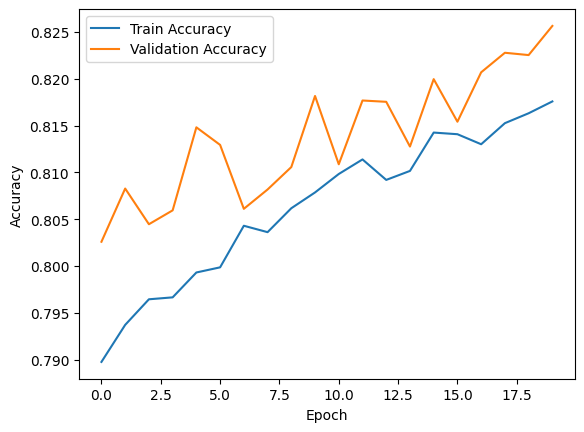

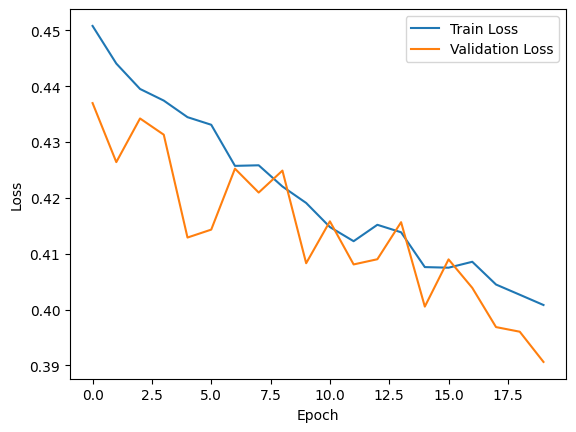

In [7]:
# Evaluation

# Training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


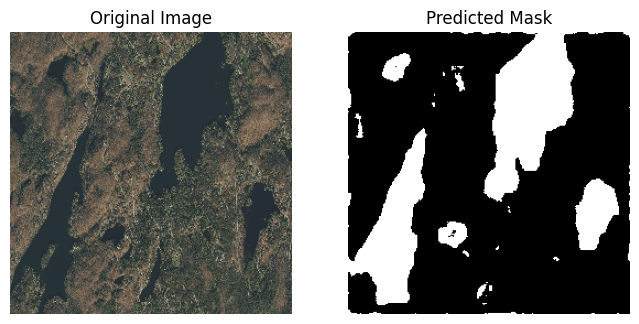

In [7]:
# Load and test model

model = tf.keras.models.load_model('unet_model.keras')
test_image_path = os.getcwd() + '/test_image_1.png' # Unseen image

img = image.load_img(test_image_path, target_size=(256, 256))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0

predicted_mask = model.predict(img)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

plt.figure(figsize=(8, 8))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

# Display the predicted mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()